# Generate Training data for KSS events (speech/no speech)

Once generated the training data is saved.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import IPython
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from audio import Audio
from kss_df import KssDf, KssDfType
from kss_speech import KssSpeech
from transformers import SlidingWindow

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Data Preparation
Create features and labels

### Training and Validation Ids

In [2]:
kss_trn_ids = ['1_0000', '1_0001', '1_0002', '1_0003']
kss_val_ids = ['1_0004', '1_0005']

### Character and Syllable Dataframes


In [3]:
# from kss_chunk import KssChunk
#
# from marker_df import MarkerDf
# # # disp.file_source('marker_df.py', label='marker_df.py ')
# #
# # chunk_dir = 'data/korean-single-speaker/kss_chunks'
# #
# # markers_char = MarkerDf.read_csv(f'{chunk_dir}/chunk_char.csv')
# # markers_syl = MarkerDf.read_csv(f'{chunk_dir}/chunk_syl.csv')
# markers_char_df, markers_syl_df = KssChunk.load_all()
# markers_char = MarkerDf(markers_char_df)
# markers_syl = MarkerDf(markers_syl_df)


kdfs = [KssDf(id) for id in kss_trn_ids]

# Below will be deprecated eventually
char_trn_dfs = [kdf.load_csv(type=KssDfType.CHAR) for kdf in kdfs]
syl_trn_dfs = [kdf.load_csv(type=KssDfType.SYL) for kdf in kdfs]
char_trn_df = pd.concat(char_trn_dfs)
syl_trn_df = pd.concat(syl_trn_dfs)

### Event Markers

#### Event Marker Data

In [4]:
# disp.obj(markers_char.df, 'Character DataFrame')
# disp.obj(markers_char.df.describe(), 'Character DataFrame Statistics')
# disp.obj(markers_syl.df, 'Syllable DataFrame')
# disp.obj(markers_syl.df.describe(), 'Syllable DataFrame Statistics')

disp.obj(char_trn_df, 'All Char Training DFs')
disp.obj(syl_trn_df, 'All Syl Training DFs')

All Char Training DFs

,char,start,stop,kssid,audio
0,0,0.00000,0.14298,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
1,ᄀ,0.14298,0.17326,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
2,ᅳ,0.17326,0.25143,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
3,ᆫ,0.25143,0.30110,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
4,ᅳ,0.30110,0.39456,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...,...
19,ᅵ,1.78153,1.83571,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav
20,ᆫ,1.83571,1.97293,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav
21,ᄃ,1.97293,1.98396,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav
22,ᅡ,1.98396,2.19790,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav


All Syl Training DFs

,syl,start,stop,kssid,audio
0,0,0.00000,0.14298,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
1,그,0.14298,0.25143,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
2,는,0.25143,0.49473,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
3,0,0.49473,0.52397,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
4,괜,0.52397,0.71846,1_0000,./data/korean-single-speaker/kss/1/1_0000.wav
...,...,...,...,...,...
8,이,1.45550,1.53270,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav
9,아,1.53270,1.75352,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav
10,낀,1.75352,1.97293,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav
11,다,1.97293,2.19790,1_0003,./data/korean-single-speaker/kss/1/1_0003.wav


#### Intervals (Deprecated?)

In [5]:
# disp.obj(markers_char.intervals(), 'Char Intervals')
# disp.obj(markers_char.intervals().describe(), 'Char Interval statistics')
# disp.obj(markers_syl.intervals(), 'Syl Intervals')
# disp.obj(markers_syl.intervals().describe(), 'Syl Interval statistics')


### Features and Labels

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec

#### Labels

True/False  Speech/No Speech

#### Features

Base waveform: RMS calculation (via librosa) of audio wav file
This significantly reduces the feature space with little impact to learning

Features are a sliding window on the base RMS waveform.

#### Mapping Label to Feature

It's easier to understand visually:

For a Sliding Window size = 16
```
     Sliding Window[6]           sliding_window[6].shape = (16,)
 012345 6789012345678901 2345678  index visualization
 ------|----------------|-------  waveform
                   |
                   V              y-offset = 11
 000000 0000000011111111 1111000  speech/no speech labels
                   1              label corresponding to sliding_window[6] -> label[17]


Mapping of sliding window to label
sliding_window[0]  -> 0 label[11]
sliding_window[1]  -> 0 label[12]
sliding_window[2]  -> 1 label[13]
sliding_window[3]  -> 1 label[14]
sliding_window[4]  -> 1 label[15]
sliding_window[5]  -> 1 label[16]
sliding_window[6]  -> 1 label[17]
sliding_window[7]  -> 1 label[18]
...
sliding_window[11] -> 1 label[24]
sliding_window[12] -> 1 label[25]
sliding_window[13] -> 0 label[26]
sliding_window[14] -> 0 label[27]
...
```

For our speech analysis, what comes after does have an effect on the present, but the past has more of
an impact. So say for this example, we look behind 11 points, and look ahead 4 points. This gives us a total window
size of 16 points (since we include our current point). So our sliding window has a size of 16.

So for the very first sliding window,

`window[0]` has `waveform[0:15]` and the associated label is `label[11]` -> `0 [Speech Not Present]`.

As we continue to slide the window, say 6 more times,

`window[6]` -> `waveform[17]` -> `label[17]` -> `1 [Speech Present]`.

This will generate our `y` that we want the window data to predict. So

```
X (feature)                 |  y (label)
window[0] = waveform[0:16]  |  y[0] = label[11] = 0
window[1] = waveform[1:17]  |  y[1] = label[12] = 0
window[2] = waveform[2:18]  |  y[2] = label[13] = 1
window[3] = waveform[3:19]  |  y[3] = label[14] = 1
window[4] = waveform[4:20]  |  y[4] = label[15] = 1
...
```

Note that the `y` we predict will be offset from the actual waveform by our "look behind" of 11 points. This is
the "y-offset". So later after we predict `y`, we will need to shift it by `y-offset` to align it with the
original labels and waveform.

### Feature Prep and Inspection

Generate the Feature data (X)


#### AudioPlexer Usage and Inspection

AudioPlexer will be used to generate the Feature (X) data.
Use `audio_plexer.ipynb` and `audio.ipynb` to explore AudioPlexer and Audio classes.

## Training

### Generate Training Features

Generate Training Features to be used for training our model

TODO: Incorporate MFCCs

In [6]:
# training_files= markers_syl.df['audio'].unique()
training_files= char_trn_df['audio'].unique()

disp.obj(training_files, 'Training Files')

Training Files

array(['./data/korean-single-speaker/kss/1/1_0000.wav',
       './data/korean-single-speaker/kss/1/1_0001.wav',
       './data/korean-single-speaker/kss/1/1_0002.wav',
       './data/korean-single-speaker/kss/1/1_0003.wav'], dtype=object)

In [7]:
# TODO: Move SlidingWindow to model (and take out of kss_speech_maker)
def kss_speech_maker(kdf):
    a = Audio(kdf.audio_path, n_fft=256, n_hops=4, n_mfcc=3)
    df = kdf.load_csv(type=KssDfType.SYL)
    sw = SlidingWindow(window=128, offset=64)
    return KssSpeech(df, a, sw)

#TODO: kspeech windowing (sliding window calcs) should not reduce training size
# Audio Comprehension
kspeech_trn_list = [ kss_speech_maker(kdf) for kdf in kdfs]

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
SlidingWindow[DEBUG]: Initial X shape: (1, 2431)
SlidingWindow[DEBUG]: Pad Size: (64, 191)
SlidingWindow[DEBUG]: Padded X: (2686,)
SlidingWindow[INFO]: np sliding window shape: (2559, 128)
SlidingWindow[DEBUG]: Initial y shape: (2431,)
SlidingWindow[DEBUG]: final y shape: (2431,)
SlidingWindow[DEBUG]: Final X shape: (2431, 128)
SlidingWindow[DEBUG]: Transform shapes, X: (1, 2431), y:--
SlidingWindow[DEBUG]: Pad Size: (64, 191)
SlidingWindow[DEBUG]: Padded X: (2686,)
SlidingWindow[DEBUG]: X shape: (1, 2431), fitted shape: (2559, 128)
SlidingWindow[DEBUG]: X shape: (1, 2431), fitted shape: (2431, 128)
Audio[WARNING]: Modifying input wav from size 175173 to 175232

In [8]:
# TODO: Deprecate this cell

# from audio_plexer import AudioPlexer
#
#
# ap_params_train = {
#     'n_fft': 256,
#     'n_hops':  4,
#     'sliding_window_size': 128,
#     'sliding_offset': 64
# }
#
# # AudioPlexer will take the training files and allow for wav form manipulations.
# ap = AudioPlexer(training_files, **ap_params_train)
#
# print(f'all audio length (wav samples) {ap.size}, duration: {ap.size/ap.sr}')
# ap_rms = ap.rms().flatten()
#
# is_speech_wav = ap.speech_from_interval(syl_trn_df, missing_val=False)
# is_speech_rms = ap.to_rms(is_speech_wav.astype(float)).flatten()
#
#
# print(f'wav shape: {ap.wav().shape}')
# print(f'wav rms shape: {ap_rms.shape}')
# print(f'is_speech_wav shape: {is_speech_wav.shape}')
# print(f'is_speech_rms shape: {is_speech_rms.shape}')

In [9]:
[print(f'kspeech rms {kspeech.rms.shape}') for kspeech in kspeech_trn_list]
[print(f'kspeech is speech {kspeech.is_speech.shape}') for kspeech in kspeech_trn_list]

trns_wav = np.concatenate([kspeech.audio.wav for kspeech in kspeech_trn_list])
trns_rms = np.concatenate([kspeech.rms for kspeech in kspeech_trn_list])
trns_speech = np.concatenate([kspeech.is_speech for kspeech in kspeech_trn_list])



kspeech rms (2431,)
kspeech rms (2739,)
kspeech rms (1214,)
kspeech rms (1592,)
kspeech is speech (2431,)
kspeech is speech (2739,)
kspeech is speech (1214,)
kspeech is speech (1592,)


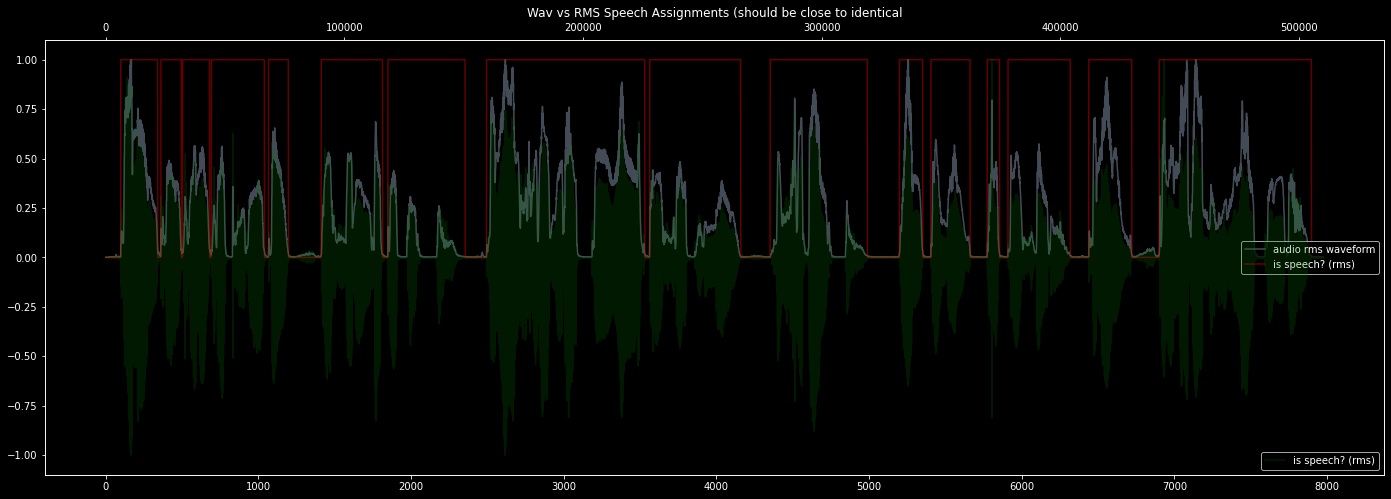

{'label': 'Full Audio'}


Full Audio

In [10]:
fig, ax1  = plt.subplots(1, 1, figsize=(24,8))

ax1.set_title(f'Wav vs RMS Speech Assignments (should be close to identical')
ax1.plot(trns_rms, color='slategray', alpha=0.6, label='audio rms waveform')
ax1.plot(trns_speech, color='red', alpha=0.4, label='is speech? (rms)')
ax1.legend(loc='center right')
ax1a = ax1.twiny()
ax1a.plot(trns_wav, color='green', alpha=0.2, label='is speech? (rms)')
ax1a.legend(loc='lower right')

plt.show()
disp.audio(data=trns_wav, rate=44100, label='Full Audio')


### X_train and y_train generation

In [11]:
# TODO: Move windowed features to pipeline so we can tune for these
# sw_size = ap.sliding_window_size
# sw_offset = ap.sliding_offset # 96//2
# X_train, y_train = ap.sliding_window_features(ap_rms, y=is_speech_rms, window=sw_size, offset=sw_offset)
print('kspeech features shapes')
print([kspeech.features.shape for kspeech in kspeech_trn_list])
print([kspeech.is_speech.shape for kspeech in kspeech_trn_list])
print('concatenated features shape')
X_trn = np.concatenate([kspeech.features for kspeech in kspeech_trn_list], axis=0)


y_trn = trns_speech
print(X_trn.shape, y_trn.shape)

kspeech features shapes
[(2431, 128), (2739, 128), (1214, 128), (1592, 128)]
[(2431,), (2739,), (1214,), (1592,)]
concatenated features shape
(7976, 128) (7976,)


In [12]:
# Save
import joblib
from filename_versioner import FilenameVersioner

def same_as_last_save(obj, full_fn):
    if isinstance(obj, np.ndarray):
        return np.array_equal(obj, joblib.load(full_fn))
    if isinstance(obj, tuple):
        # This assumes a 2 dim tuple containing np arrays, because I'm lazy
        saved_tuple = joblib.load(full_fn)
        tuple1 =  np.array_equal(obj[0], saved_tuple[0])
        tuple2 = np.array_equal(obj[1], saved_tuple[1])
        return tuple1 and tuple2
    else:
        return obj == joblib.load(full_fn)

def incrementer(fn, ext, base_dir):
    return FilenameVersioner((fn, ext), base_dir=base_dir).increment_version()

def should_save(obj, old_saved_path):
    return not old_saved_path or not same_as_last_save(obj, old_saved_path)

def save_new_version(obj, fv):
    old_saved_path = fv.get_latest_path()
    if should_save(obj, old_saved_path):
        new_path = fv.increment_version()
        print(f'Saving to: {new_path}')
        joblib.dump(obj, new_path)
    else:
        print(f'No changes from: {old_saved_path}')


# # Save trained file
# TODO: rms_trn should be our X_trn (and X_trn_sw should move to model as a transformer)
save_dir = './data/model'
fv_x = FilenameVersioner(('x_trn_sw', 'joblib'), base_dir=save_dir)
fv_y = FilenameVersioner(('y_trn_sw', 'joblib'), base_dir=save_dir)
fv_rms = FilenameVersioner(('rms_trn', 'joblib'), base_dir=save_dir)
fv_kspeech_list = FilenameVersioner(('kspeech_trn_list', 'joblib'), base_dir=save_dir)
# fv_ap = FilenameVersioner(('ap_trn', 'joblib'), base_dir=save_dir)

save_new_version(X_trn, fv_x)
save_new_version(y_trn, fv_y)
save_new_version((trns_rms, trns_speech), fv_rms)
save_new_version(kspeech_trn_list, fv_kspeech_list)
# save_new_version(ap, fv_ap)



No changes from: ./data/model/x_trn_sw.2.joblib
No changes from: ./data/model/y_trn_sw.5.joblib
No changes from: ./data/model/rms_trn.5.joblib
No changes from: ./data/model/kspeech_trn_list.0.joblib
